In [3]:
%load_ext autoreload
%autoreload 2 

import gymnasium as gym
# Do NOT import gymnasium.wrappers yet, we will handle that in the next step
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
import time

from collections import deque
from agent import Agent, FloatTensor
from replay_buffer import ReplayMemory, Transition
from  torch.autograd import Variable

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
device = torch.device("cuda" if use_cuda else "cpu")

BATCH_SIZE = 64  
TAU = 0.005 # 1e-3   # for soft update of target parameters
gamma = 0.99
LEARNING_RATE = 0.001
TARGET_UPDATE = 10

num_episodes = 20000
print_every = 10
hidden_dim = 16 ## 64 ## 16
min_eps = 0.01
max_eps_episode = 50

# env = gym.make('LunarLander-v3')
env = gym.make('LunarLander-v3', render_mode="rgb_array")
# env = gym.wrappers.Monitor(env, directory="monitors", force=True)
# Old/Broken line:
# env = gym.wrappers.Monitor(env, directory="monitors", force=True)

# NEW/Fixed Line (Requires a separate import):
env = gym.wrappers.RecordVideo(env, video_folder="monitors", disable_logger=True)     
space_dim =  env.observation_space.shape[0] # n_spaces
action_dim = env.action_space.n # n_actions  
print('input_dim: ', space_dim, ', output_dim: ', action_dim, ', hidden_dim: ', hidden_dim)

threshold = env.spec.reward_threshold
print('threshold: ', threshold)

agent = Agent(space_dim, action_dim, hidden_dim)

    
def epsilon_annealing(i_epsiode, max_episode, min_eps: float):
    ##  if i_epsiode --> max_episode, ret_eps --> min_eps
    ##  if i_epsiode --> 1, ret_eps --> 1  
    slope = (min_eps - 1.0) / max_episode
    ret_eps = max(slope * i_epsiode + 1.0, min_eps)
    return ret_eps        

def save(directory, filename):
    torch.save(agent.q_local.state_dict(), '%s/%s_local.pth' % (directory, filename))
    torch.save(agent.q_target.state_dict(), '%s/%s_target.pth' % (directory, filename))


d:\Capstone\vs_code\lunar.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at d:\Capstone\vs_code\lunar\Deep-Reinforcement-Learning-Algorithms\LunarLander-v2-DQN\monitors folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


input_dim:  8 , output_dim:  4 , hidden_dim:  16
threshold:  200


In [5]:
def run_episode(env, agent, eps):
    """Play an epsiode and train

    Args:
        env (gym.Env): gym environment (CartPole-v0)
        agent (Agent): agent will train and get action        
        eps (float): eps-greedy for exploration

    Returns:
        int: reward earned in this episode
    """
    # state = env.reset()
    state, info = env.reset()
    done = False
    total_reward = 0
    

    # while not done:

    #     action = agent.get_action(FloatTensor([state]) , eps)
        
    #     next_state, reward, done, _ = env.step(action.item())

    #     total_reward += reward

    #     if done:
    #         reward = -1
                    
    #     # Store the transition in memory
    #     agent.replay_memory.push(
    #             (FloatTensor([state]), 
    #              action, # action is already a tensor
    #              FloatTensor([reward]), 
    #              FloatTensor([next_state]), 
    #              FloatTensor([done])))
                 

    #     if len(agent.replay_memory) > BATCH_SIZE:

    #         batch = agent.replay_memory.sample(BATCH_SIZE)
            
    #         agent.learn(batch, gamma)

    #     state = next_state


    # return total_reward

    while not done:
        action = agent.get_action(FloatTensor([state]) , eps)
        
        # 2. Correct Step Unpacking
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated # <--- CHANGE MADE HERE
        
        agent.step(state, action.item(), reward, next_state, done)
        state = next_state
        total_reward += reward
        
    return total_reward


In [6]:
def train():
    global agent
    agent = Agent(space_dim, action_dim, hidden_dim)
    # --- END CRITICAL FIX ---
    

    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []    
    
    time_start = time.time()

    for i_episode in range(num_episodes):
        eps = epsilon_annealing(i_episode, max_eps_episode, min_eps)
        score = run_episode(env, agent, eps)

        scores_deque.append(score)
        scores_array.append(score)
        
        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)

        dt = (int)(time.time() - time_start)
            
        if i_episode % print_every == 0 and i_episode > 0:
            print('Episode: {:5} Score: {:5}  Avg.Score: {:.2f}, eps-greedy: {:5.2f} Time: {:02}:{:02}:{:02}'.\
                    format(i_episode, score, avg_score, eps, dt//3600, dt%3600//60, dt%60))
            
        if len(scores_deque) == scores_deque.maxlen:
            ### threshold = 200
            if np.mean(scores_deque) >= threshold: 
                print('\n Environment solved in {:d} episodes!\tAverage Score: {:.2f}'. \
                    format(i_episode, np.mean(scores_deque)))
                break

                        
        if i_episode % TARGET_UPDATE == 0:
            agent.q_target.load_state_dict(agent.q_local.state_dict()) 
    
    return scores_array, avg_scores_array

scores, avg_scores = train()

C:\Users\tanis\AppData\Local\Temp\ipykernel_2124\2805764430.py:50: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  action = agent.get_action(FloatTensor([state]) , eps)


Episode:    10 Score: -272.5222808903464  Avg.Score: -198.90, eps-greedy:  0.80 Time: 00:00:02
Episode:    20 Score: -145.27761845186802  Avg.Score: -255.71, eps-greedy:  0.60 Time: 00:00:03
Episode:    30 Score: -485.79788066260335  Avg.Score: -294.03, eps-greedy:  0.41 Time: 00:00:04
Episode:    40 Score: -1281.3091046500128  Avg.Score: -369.88, eps-greedy:  0.21 Time: 00:00:05
Episode:    50 Score: -891.3987936730832  Avg.Score: -426.67, eps-greedy:  0.01 Time: 00:00:05
Episode:    60 Score: -774.7404962999684  Avg.Score: -474.77, eps-greedy:  0.01 Time: 00:00:06
Episode:    70 Score: -639.715050562916  Avg.Score: -493.42, eps-greedy:  0.01 Time: 00:00:07
Episode:    80 Score: -580.8924178741146  Avg.Score: -516.38, eps-greedy:  0.01 Time: 00:00:08
Episode:    90 Score: -462.1134042676369  Avg.Score: -542.93, eps-greedy:  0.01 Time: 00:00:09
Episode:   100 Score: -1127.1459090556352  Avg.Score: -621.24, eps-greedy:  0.01 Time: 00:00:10
Episode:   110 Score: -410.21745601574736  Avg.

length of scores:  20000 , len of avg_scores:  20000


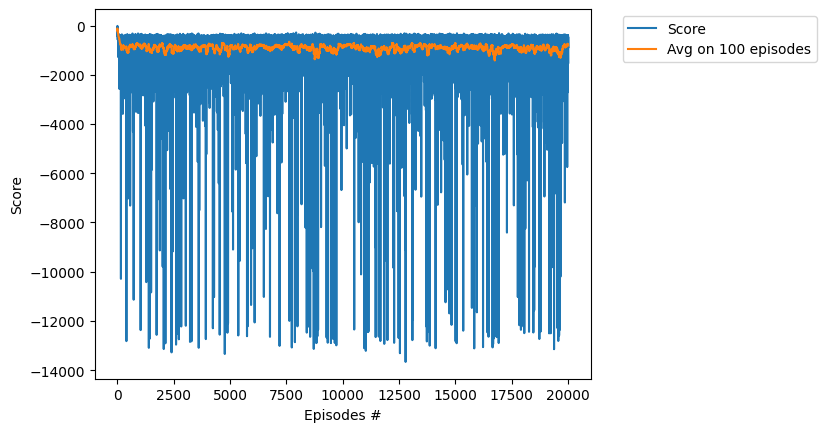

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [8]:
save('dir_chk', 'LunarLander-v2')